# Продолжение кода ВКР

## Разработка и обучение моделей

Учитывая тот факт, что прогнозируемые переменные - непрерывные, для выполнения задачи прогнозирования прочности при растяжении целесообразно использовать **регрессионные модели**.

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import utils

### Прогнозирование прочности при растяжении

#### Multiple Linear Regression model

Рассмотрим модель множественной линейной регрессии при стандартных параметрах. Вероятность удовлетворительного прогноза - практически нулевая, ведь на этапе разведочного анализа данных никаких линейный корреляционных связей обнаружено не было. Тем не мене, в учебных целях разработаем модель и посмотрим на результаты.

In [3]:
# загрузим данные - готовый датасет после избавления от выбросов
# повторим нормализацию с помощью MinMaxScaler отдельно для зависимой и независимых переменных
df = pd.read_csv('/Users/kusita_1/Desktop/df compositum clean.csv', index_col=0)
df.head(3)

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,1.857143,2030.0,738.736842,36.513195,22.267857,178.163161,210.0,70.0,3000.0,220.0,0.0,4.0,57.0
1,1.857143,2030.0,738.736842,50.000000,23.750000,284.615385,210.0,70.0,3000.0,220.0,0.0,4.0,60.0
2,1.857143,2030.0,738.736842,49.900000,28.992783,284.615385,210.0,70.0,3000.0,220.0,0.0,4.0,70.0


In [3]:
# выполним нормализацию повторно, но теперь отдельно для зависимой и независимых переменных
# сформируем датасеты независимых признаков - x и y для зависимой переменной - прочности при растяжении
min_max_scaler_x = preprocessing.MinMaxScaler()
min_max_scaler_y = preprocessing.MinMaxScaler()

df_scaled_x = min_max_scaler_x.fit_transform(df.drop('Прочность при растяжении, МПа', axis=1))
df_scaled_y = min_max_scaler_y.fit_transform(df[['Прочность при растяжении, МПа']])

In [4]:
# посмотрим на массив с независимыми признаками
df_scaled_x[:3]

array([[0.2817149 , 0.64718094, 0.44569587, 0.        , 0.49872336,
        0.        , 0.15717681, 0.29929831, 0.5046413 , 0.        ,
        0.28889872, 0.49385823],
       [0.2817149 , 0.64718094, 0.44569587, 0.09042597, 0.60920244,
        0.49342302, 0.15717681, 0.29929831, 0.5046413 , 0.        ,
        0.28889872, 0.54337708],
       [0.2817149 , 0.64718094, 0.44569587, 0.08975549, 1.        ,
        0.49342302, 0.15717681, 0.29929831, 0.5046413 , 0.        ,
        0.28889872, 0.7084399 ]])

In [5]:
# посмотрим на набор значений зависимой переменной
df_scaled_y[:3]

array([[0.71718721],
       [0.71718721],
       [0.71718721]])

In [6]:
# разобъем наборы на тестовую и тренировочную выборки (на 30% и 70%, соответственно, по условиям задачи)
x_scaled_train, x_scaled_test, y_scaled_train, y_scaled_test = train_test_split(df_scaled_x, df_scaled_y, train_size=0.7, random_state=73)

In [7]:
# проверим размерность получившихся массивов 
print(x_scaled_train.shape)
print(x_scaled_test.shape)
print(y_scaled_train.shape)
print(y_scaled_test.shape)

(716, 12)
(307, 12)
(716, 1)
(307, 1)


In [8]:
# обучим модель
lr = LinearRegression()
lr.fit(x_scaled_train, y_scaled_train)

LinearRegression()

In [9]:
# выведением значение перечения прямой оси у
print(lr.intercept_)

[0.61019889]


In [10]:
# выведем коэффициенты регрессии
lr.coef_

array([[ 0.01296173, -0.1177195 ,  0.03312327, -0.12097139, -0.01360954,
        -0.02763038,  0.01277225, -0.01886626,  0.03398655,  0.01147658,
        -0.05862091,  0.05298667]])

In [11]:
# напишем уравнение линейной регрессии, где У - зависимая переменная, intercept - свободный член
df_x = df.drop('Прочность при растяжении, МПа', axis=1)
str1 = f"Y = {lr.intercept_} + "
for coef, column in zip(lr.coef_.ravel(), df_x.columns):
    str1 += str(np.round(coef, 3)) + " * " + str(column) + " + "
str1

'Y = [0.61019889] + 0.013 * Соотношение матрица-наполнитель + -0.118 * Плотность, кг/м3 + 0.033 * модуль упругости, ГПа + -0.121 * Количество отвердителя, м.% + -0.014 * Содержание эпоксидных групп,%_2 + -0.028 * Температура вспышки, С_2 + 0.013 * Поверхностная плотность, г/м2 + -0.019 * Модуль упругости при растяжении, ГПа + 0.034 * Потребление смолы, г/м2 + 0.011 * Угол нашивки, град + -0.059 * Шаг нашивки + 0.053 * Плотность нашивки + '

In [12]:
# спрогнозируем значения прочности при растяжении
y_pred = lr.predict(x_scaled_test)
# преобразуем массив в таблицу pandas
y_pred = pd.DataFrame(y_pred)
y_pred.head(3)

,0
0,0.467578
1,0.556094
2,0.513590


In [13]:
# преобразуем массив тестовых данных в таблицу pandas
y_scaled_test = pd.DataFrame(y_scaled_test)
y_scaled_test.head(3)

,0
0,0.665200
1,0.459896
2,1.000000


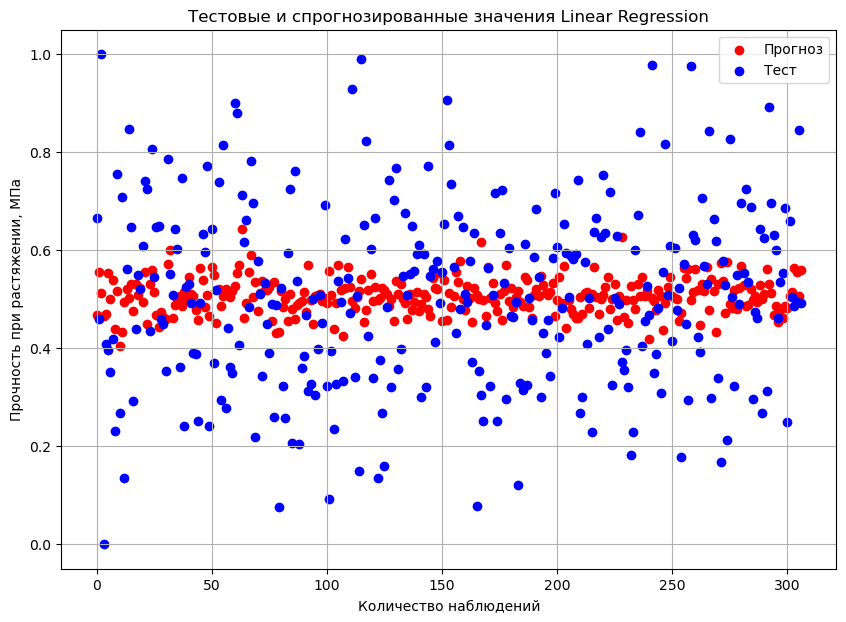

In [14]:
# визуализируем настоящие (отмечены синим цветом) и прогнозные значения (отмечены красным цветом)
plt.figure(figsize = (10, 7))
plt.title("Тестовые и спрогнозированные значения Linear Regression")
plt.scatter(y_pred.index, y_pred, label = "Прогноз", color = "r")
plt.scatter(y_scaled_test.index, y_scaled_test, label = "Тест", color = "b")
plt.xlabel("Количество наблюдений")
plt.ylabel("Прочность при растяжении, МПа")
plt.legend()
plt.grid(True);

Вывод: прогноз неудовлетворительный, как и ожидалось. Однако, результат визуально несколько лучше, чем при использовании аналогичной модели при прогнозировании модуля упругости при растяжении.

In [15]:
# используем встроенные в библиотеку sklearn метрики для вычисления ошибки
y_pred = np.array(y_pred)
y_scaled_test = np.array(y_scaled_test)
lr_rmse = np.sqrt(metrics.mean_squared_error(y_scaled_test, y_pred))
lr_r2_score = r2_score(y_scaled_test, y_pred)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_scaled_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_scaled_test, y_pred))
print('Root Mean Squared Error:', 
      np.sqrt(metrics.mean_squared_error(y_scaled_test, y_pred)))
print('r2 score:', r2_score(y_scaled_test, y_pred))

Mean Absolute Error: 0.15027198787016202
Mean Squared Error: 0.03469769882827305
Root Mean Squared Error: 0.1862731833310234
r2 score: -0.02969466520555608


In [16]:
# вернем значения в исходный вид
y_pred_df = pd.DataFrame(y_pred)
y_pred_df = min_max_scaler_y.inverse_transform(y_pred)

y_test_df = pd.DataFrame(y_scaled_test)
y_test_df = min_max_scaler_y.inverse_transform(y_scaled_test)

In [17]:
# посмотрим первые 3 спрогнозированных значения прочности при растяжении
y_pred_df[:3]

array([[2369.64434099],
       [2593.18029453],
       [2485.84069091]])

In [18]:
# посмотрим первые 3 настоящих значения прочности при растяжении
y_test_df[:3]

array([[2868.71302844],
       [2350.24387   ],
       [3714.20712559]])

In [19]:
# создадим словарь для последующего формирования таблицы с результатами для каждой модели 
metrics_df = {'Регрессор': ['Linear_Regression'], 'RMSE': [lr_rmse], 'r2 score': [lr_r2_score]}
metrics_df = pd.DataFrame(metrics_df)
metrics_df

,Регрессор,RMSE,r2 score
0,Linear_Regression,0.186273,-0.029695


Вывод по первой модели:

модель дает прогноз хуже наивного. 

In [20]:
# загрузим таблицу с нормализованными с помощью Normalizer() данными без целевого столбца - 'Прочность при растяжении, МПа'
df_norm_x = pd.read_csv('/Users/kusita_1/Desktop/df compositum norm resistance.csv', index_col=0)
df_norm_x.head(3)

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,0.000848,0.926480,0.337155,0.016664,0.010163,0.081313,0.095843,0.031948,0.100407,0.0,0.001826,0.026014
1,0.000843,0.921612,0.335384,0.022700,0.010782,0.129214,0.095339,0.031780,0.099879,0.0,0.001816,0.027240
2,0.000843,0.921463,0.335329,0.022651,0.013160,0.129193,0.095324,0.031775,0.099863,0.0,0.001816,0.031775


In [21]:
# разобъем наборы на тестовую и тренировочную выборки (на 30% и 70%, соответственно, по условиям задачи)
df_norm_y = df[['Прочность при растяжении, МПа']]
x_norm_train, x_norm_test, y_norm_train, y_norm_test = train_test_split(df_norm_x, df_norm_y, train_size=0.7, random_state=73)

In [22]:
# проверим размерность получившихся массивов 
print(x_norm_train.shape)
print(x_norm_test.shape)
print(y_norm_train.shape)
print(y_norm_test.shape)

(716, 12)
(307, 12)
(716, 1)
(307, 1)


In [23]:
# обучим модель
lr = LinearRegression()
lr.fit(x_norm_train, y_norm_train)

LinearRegression()

In [24]:
# спрогнозируем значения прочности при растяжении
y_pred = lr.predict(x_norm_test)

In [25]:
# используем встроенные в библиотеку sklearn метрики для вычисления ошибки
lr_norm_rmse = np.sqrt(metrics.mean_squared_error(y_norm_test, y_pred))
lr_norm_r2_score = r2_score(y_norm_test, y_pred)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_norm_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_norm_test, y_pred))
print('Root Mean Squared Error:', 
      np.sqrt(metrics.mean_squared_error(y_norm_test, y_pred)))
print('r2 score:', r2_score(y_norm_test, y_pred))

Mean Absolute Error: 379.19442324215925
Mean Squared Error: 221014.88128359534
Root Mean Squared Error: 470.12219824594047
r2 score: -0.028440182745511855


In [26]:
# приведем наборы значений зависимой переменной к табличному виду для последующей визуализации
y_pred = pd.DataFrame(y_pred)
y_norm_test = pd.DataFrame(y_norm_test).reset_index(drop=True)
y_norm_test.head(3)

,"Прочность при растяжении, МПа"
0,2868.713028
1,2350.243870
2,3714.207126


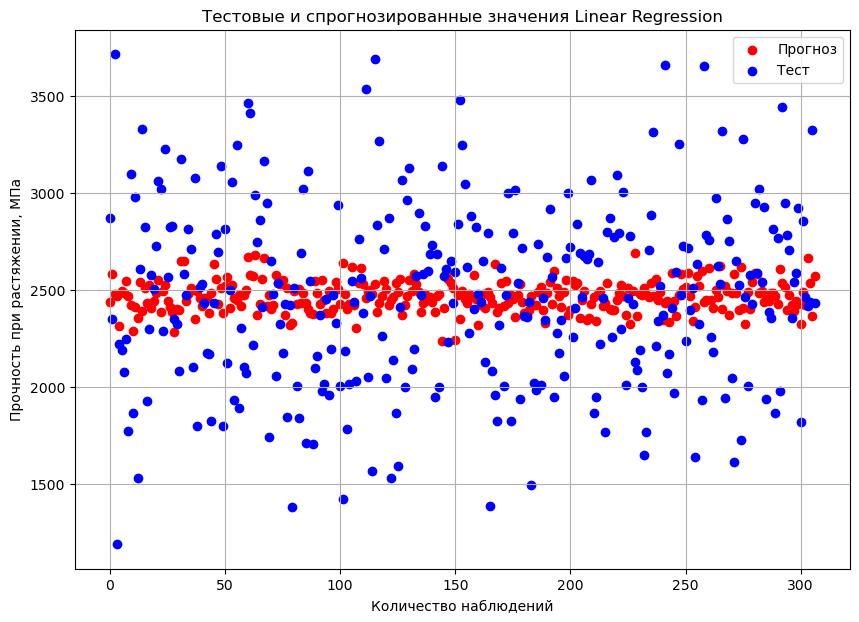

In [27]:
# визуализируем настоящие (отмечены синим цветом) и прогнозные значения (отмечены красным цветом)
plt.figure(figsize = (10, 7))
plt.title("Тестовые и спрогнозированные значения Linear Regression")
plt.scatter(y_pred.index, y_pred, label = "Прогноз", color = "r")
plt.scatter(y_norm_test.index, y_norm_test, label = "Тест", color = "b")
plt.xlabel("Количество наблюдений")
plt.ylabel("Прочность при растяжении, МПа")
plt.legend()
plt.grid(True);

Вывод: 
прогноз хуже наивного и виузально хуже, чем при масштабировании данных.

In [28]:
# добавим в таблицу данные по второй модели
metrics_df.loc[len(metrics_df.index)] = ['Linear_Regression_sample_normalization', lr_norm_rmse, lr_norm_r2_score] 
metrics_df

,Регрессор,RMSE,r2 score
0,Linear_Regression,0.186273,-0.029695
1,Linear_Regression_sample_normalization,470.122198,-0.028440


Корреляционные коэффициенты столбца "Угол нашивки" и зависимых переменных одинаковые. Учитывая отсутствие различий в прогнозе при сравнении моделей с категориальными и непрерывными значениями в этом солбце при прогнозировании модуля упругости при растяжении, нет смысла повторять те же процедуры для моделей прогнозирования прочности при растяжении. 

Перейдем к разработке нелинейных моделей.

#### Support Vector Regressor model

Учитывая небольшие размеры датасета, наличие четких границ между зависимыми переменными, судя по разведочному анализу данных, в качестве первого метода, использующим нелинейную функцию для прогнозирования, применим метод опорных векторов.

In [29]:
# первоначально будем использовать нормализованный с помощью MinMaxScaler() датасет
# разобъем наборы на тестовую и тренировочную выборки (на 30% и 70%, соответственно, по условиям задачи)
x_scaled_train, x_scaled_test, y_scaled_train, y_scaled_test = train_test_split(df_scaled_x, df_scaled_y, train_size=0.7, random_state=73)

In [30]:
# проверим размерность получившихся массивов 
print(x_scaled_train.shape)
print(x_scaled_test.shape)
print(y_scaled_train.shape)
print(y_scaled_test.shape)

(716, 12)
(307, 12)
(716, 1)
(307, 1)


In [32]:
# обучим модель
y_scaled_train = np.array(y_scaled_train).ravel()
svr = SVR(kernel = 'rbf', C = 50, epsilon= 0.3)
svr.fit(x_scaled_train, y_scaled_train)

SVR(C=50, epsilon=0.3)

In [33]:
# спрогнозируем значения прочности при растяжении
y_pred = svr.predict(x_scaled_test)

In [34]:
# используем встроенные в библиотеку sklearn метрики для вычисления ошибки
svr_rmse = np.sqrt(metrics.mean_squared_error(y_scaled_test, y_pred))
svr_r2_score = r2_score(y_scaled_test, y_pred)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_scaled_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_scaled_test, y_pred))
print('Root Mean Squared Error:', 
      np.sqrt(metrics.mean_squared_error(y_scaled_test, y_pred)))
print('r2 score:', r2_score(y_scaled_test, y_pred))

Mean Absolute Error: 0.1660766429737647
Mean Squared Error: 0.04163106767084144
Root Mean Squared Error: 0.20403692722358235
r2 score: -0.23545046890968369


In [35]:
# преобразуем массив в таблицу pandas
y_pred = pd.DataFrame(y_pred)
y_pred.head(3)

,0
0,0.478924
1,0.648385
2,0.526269


In [36]:
# преобразуем массив тестовых данных в таблицу pandas
y_scaled_test = pd.DataFrame(y_scaled_test)
y_scaled_test.head(3)

,0
0,0.665200
1,0.459896
2,1.000000


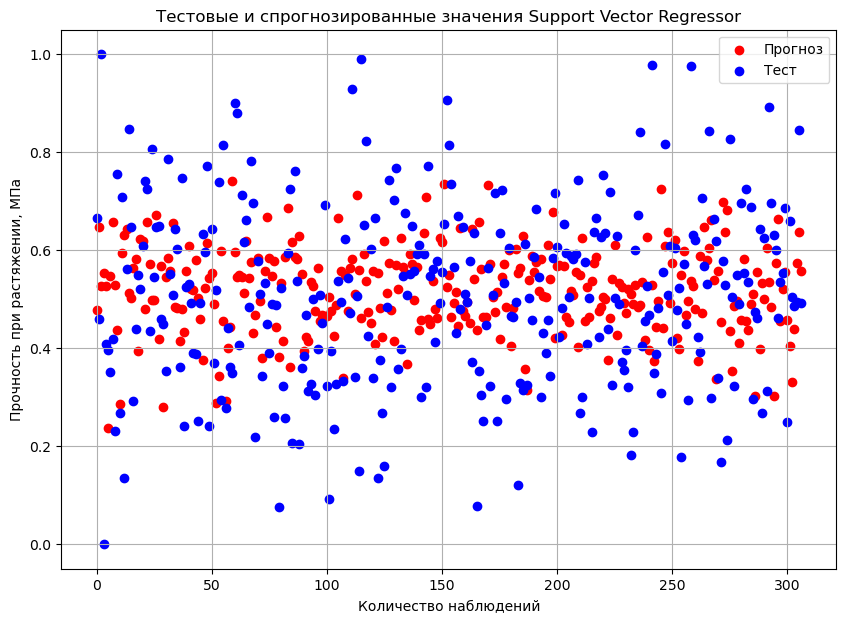

In [37]:
# визуализируем настоящие (отмечены синим цветом) и прогнозные значения (отмечены красным цветом)
plt.figure(figsize = (10, 7))
plt.title("Тестовые и спрогнозированные значения Support Vector Regressor")
plt.scatter(y_pred.index, y_pred, label = "Прогноз", color = "r")
plt.scatter(y_scaled_test.index, y_scaled_test, label = "Тест", color = "b")
plt.xlabel("Количество наблюдений")
plt.ylabel("Прочность при растяжении, МПа")
plt.legend()
plt.grid(True);

Вывод:
судя по визуализации, результат лучше, чем при применении линейной функции для прогнозирования, но по метрикам прогноз модели хуже наивного.

In [38]:
# добавим в таблицу данные по этой модели
metrics_df.loc[len(metrics_df.index)] = ['Support Vector Regressor', svr_rmse, svr_r2_score] 
metrics_df

,Регрессор,RMSE,r2 score
0,Linear_Regression,0.186273,-0.029695
1,Linear_Regression_sample_normalization,470.122198,-0.028440
2,Support Vector Regressor,0.204037,-0.235450


In [39]:
# посмотрим, будет ли изменение качества прогноза нелинейной модели при использовании функции normalize()
# разобъем наборы на тестовую и тренировочную выборки (на 30% и 70%, соответственно, по условиям задачи)
df_norm_y = df[['Прочность при растяжении, МПа']]
x_norm_train, x_norm_test, y_norm_train, y_norm_test = train_test_split(df_norm_x, df_norm_y, train_size=0.7, random_state=73)

In [40]:
# проверим размерность получившихся массивов 
print(x_norm_train.shape)
print(x_norm_test.shape)
print(y_norm_train.shape)
print(y_norm_test.shape)

(716, 12)
(307, 12)
(716, 1)
(307, 1)


In [41]:
# обучим модель
y_norm_train = np.array(y_norm_train).ravel()
svr = SVR(kernel = 'rbf', C = 50, epsilon= 0.3)
svr.fit(x_norm_train, y_norm_train)

SVR(C=50, epsilon=0.3)

In [42]:
# спрогнозируем значения прочности при растяжении
y_pred = svr.predict(x_norm_test)

In [43]:
# используем встроенные в библиотеку sklearn метрики для вычисления ошибки
svr_norm_rmse = np.sqrt(metrics.mean_squared_error(y_norm_test, y_pred))
svr_norm_r2_score = r2_score(y_norm_test, y_pred)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_norm_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_norm_test, y_pred))
print('Root Mean Squared Error:', 
      np.sqrt(metrics.mean_squared_error(y_norm_test, y_pred)))
print('r2 score:', r2_score(y_norm_test, y_pred))

Mean Absolute Error: 370.80117371091177
Mean Squared Error: 215045.05455789767
Root Mean Squared Error: 463.7295058090413
r2 score: -0.0006610139715435004


In [44]:
# преобразуем массив в таблицу pandas
y_pred = pd.DataFrame(y_pred)
y_pred.head(3)

,0
0,2441.859524
1,2464.424851
2,2447.664514


In [45]:
# преобразуем массив тестовых данных в таблицу pandas
y_norm_test = pd.DataFrame(y_norm_test).reset_index(drop=True)
y_norm_test.head(3)

,"Прочность при растяжении, МПа"
0,2868.713028
1,2350.243870
2,3714.207126


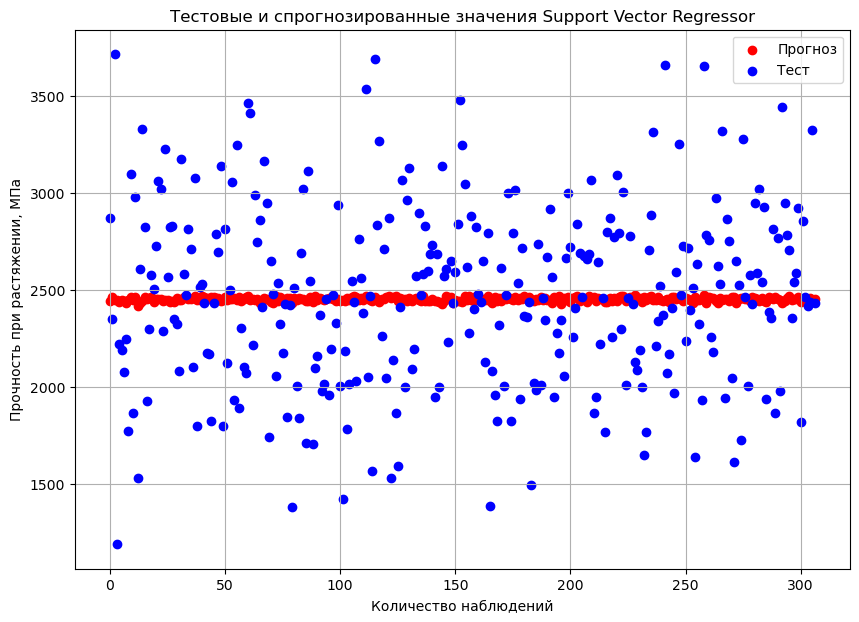

In [46]:
# визуализируем настоящие (отмечены синим цветом) и прогнозные значения (отмечены красным цветом)
plt.figure(figsize = (10, 7))
plt.title("Тестовые и спрогнозированные значения Support Vector Regressor")
plt.scatter(y_pred.index, y_pred, label = "Прогноз", color = "r")
plt.scatter(y_norm_test.index, y_norm_test, label = "Тест", color = "b")
plt.xlabel("Количество наблюдений")
plt.ylabel("Прочность при растяжении, МПа")
plt.legend()
plt.grid(True);

In [47]:
# добавим в таблицу данные по этой модели
metrics_df.loc[len(metrics_df.index)] = ['Support Vector Regressor_sample_normalization', svr_norm_rmse, svr_norm_r2_score] 
metrics_df

,Регрессор,RMSE,r2 score
0,Linear_Regression,0.186273,-0.029695
1,Linear_Regression_sample_normalization,470.122198,-0.028440
2,Support Vector Regressor,0.204037,-0.235450
3,Support Vector Regressor_sample_normalization,463.729506,-0.000661


#### Random Forest Regressor model

Попробуем применить ансамблевые методы. Метод случайного леса позволяет работать с нелинейными зависимостями, при этом не требует масштабирования и, учитывая небольшой размер данного датасета, не потребует много ресусрсов для выполнения.

In [48]:
# разделим датасет, получившийся после работы с выбросами, на зависимую и независимые переменные
df_x = df.drop('Прочность при растяжении, МПа', axis=1)
df_y = df['Прочность при растяжении, МПа']

In [49]:
df_x.head(3)

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,1.857143,2030.0,738.736842,36.513195,22.267857,178.163161,210.0,70.0,220.0,0.0,4.0,57.0
1,1.857143,2030.0,738.736842,50.000000,23.750000,284.615385,210.0,70.0,220.0,0.0,4.0,60.0
2,1.857143,2030.0,738.736842,49.900000,28.992783,284.615385,210.0,70.0,220.0,0.0,4.0,70.0


In [50]:
df_y.head(3)

0    3000.0
1    3000.0
2    3000.0
Name: Прочность при растяжении, МПа, dtype: float64

In [51]:
# разобъем наборы на тестовую и тренировочную выборки (на 30% и 70%, соответственно, по условиям задачи)
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, train_size=0.7, random_state=73)

In [52]:
# проверим размерность получившихся массивов 
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(716, 12)
(307, 12)
(716,)
(307,)


In [53]:
# обучим модель
# учитывая небольшой размер датасета, возьмем достаточно большое количество деревьев и среднее значение max_depth для предупреждения переобучения
rfr = RandomForestRegressor(n_estimators=10000, max_depth=5, random_state=73)
rfr.fit(x_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=10000, random_state=73)

In [54]:
# спрогнозируем значения прочности при растяжении
y_pred = rfr.predict(x_test)

In [55]:
# используем встроенные в библиотеку sklearn метрики для вычисления ошибки
rfr_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
rfr_r2_score = r2_score(y_test, y_pred)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', 
      np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('r2 score:', r2_score(y_test, y_pred))

Mean Absolute Error: 376.918840419464
Mean Squared Error: 219599.085517482
Root Mean Squared Error: 468.6140048243138
r2 score: -0.02185211388799635


In [56]:
# преобразуем массив в таблицу pandas
y_pred = pd.DataFrame(y_pred)
y_pred.head(3)

,0
0,2465.077499
1,2645.025612
2,2445.803701


In [57]:
# преобразуем массив тестовых данных в таблицу pandas
y_test = pd.DataFrame(y_test).reset_index(drop=True)
y_test.head(3)

,"Прочность при растяжении, МПа"
0,2868.713028
1,2350.243870
2,3714.207126


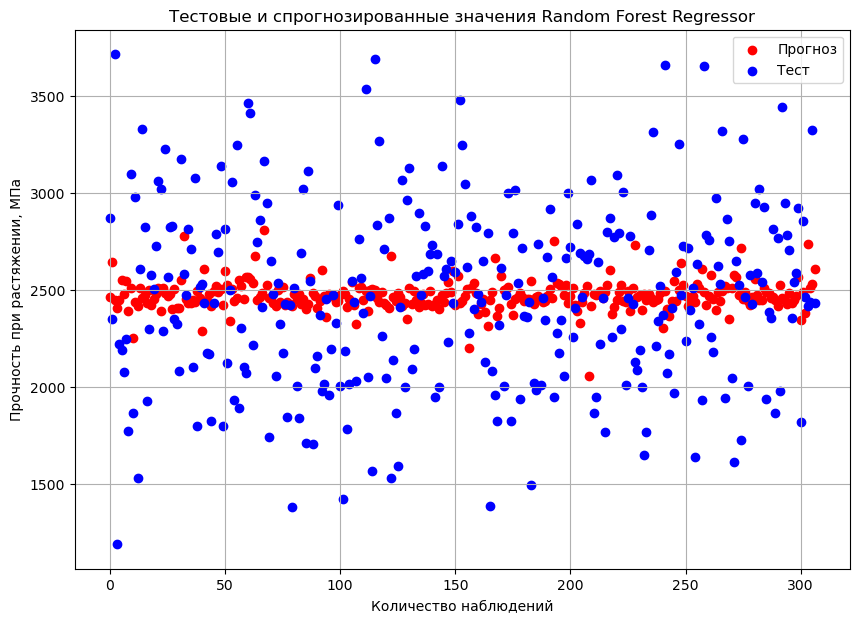

In [58]:
# визуализируем настоящие (отмечены синим цветом) и прогнозные значения (отмечены красным цветом)
plt.figure(figsize = (10, 7))
plt.title("Тестовые и спрогнозированные значения Random Forest Regressor")
plt.scatter(y_pred.index, y_pred, label = "Прогноз", color = "r")
plt.scatter(y_test.index, y_test, label = "Тест", color = "b")
plt.xlabel("Количество наблюдений")
plt.ylabel("Прочность при растяжении, МПа")
plt.legend()
plt.grid(True);

In [59]:
# добавим в таблицу данные по этой модели
metrics_df.loc[len(metrics_df.index)] = ['Random Forest Regressor', rfr_rmse, rfr_r2_score] 
metrics_df

,Регрессор,RMSE,r2 score
0,Linear_Regression,0.186273,-0.029695
1,Linear_Regression_sample_normalization,470.122198,-0.028440
2,Support Vector Regressor,0.204037,-0.235450
3,Support Vector Regressor_sample_normalization,463.729506,-0.000661
4,Random Forest Regressor,468.614005,-0.021852


#### KNeighbors Regressor model

Попробуем метод, основанный на определении расстояния между значениями и поиске ближайших для прогноза зависимой переменной. Метод не требует наличия линейных зависимостей, явное наличие которых при разведочном анализе данных доказать не удалось.

In [60]:
# учитывая принцип работы метода, для обучения модели проведем масштабирование данных
# сформируем датасеты независимых признаков - x и y для зависимой переменной - прочности при растяжении
min_max_scaler_x = preprocessing.MinMaxScaler()
min_max_scaler_y = preprocessing.MinMaxScaler()

df_scaled_x = min_max_scaler_x.fit_transform(df.drop('Прочность при растяжении, МПа', axis=1))
df_scaled_y = min_max_scaler_y.fit_transform(df[['Прочность при растяжении, МПа']])

In [61]:
# посмотрим на массив с независимыми признаками
df_scaled_x[:3]

array([[0.2817149 , 0.64718094, 0.44569587, 0.        , 0.49872336,
        0.        , 0.15717681, 0.29929831, 0.5046413 , 0.        ,
        0.28889872, 0.49385823],
       [0.2817149 , 0.64718094, 0.44569587, 0.09042597, 0.60920244,
        0.49342302, 0.15717681, 0.29929831, 0.5046413 , 0.        ,
        0.28889872, 0.54337708],
       [0.2817149 , 0.64718094, 0.44569587, 0.08975549, 1.        ,
        0.49342302, 0.15717681, 0.29929831, 0.5046413 , 0.        ,
        0.28889872, 0.7084399 ]])

In [62]:
# посмотрим на набор значений зависимой переменной
df_scaled_y[:3]

array([[0.71718721],
       [0.71718721],
       [0.71718721]])

In [63]:
# разобъем наборы на тестовую и тренировочную выборки (на 30% и 70%, соответственно, по условиям задачи)
x_scaled_train, x_scaled_test, y_scaled_train, y_scaled_test = train_test_split(df_scaled_x, df_scaled_y, train_size=0.7, random_state=73)

In [64]:
# проверим размерность получившихся массивов 
print(x_scaled_train.shape)
print(x_scaled_test.shape)
print(y_scaled_train.shape)
print(y_scaled_test.shape)

(716, 12)
(307, 12)
(716, 1)
(307, 1)


In [65]:
# обучим модель
# учитывая размер датасета, возьмем 14 соседей в качестве параметра
knn = KNeighborsRegressor(n_neighbors=14)
knn.fit(x_scaled_train, y_scaled_train)

KNeighborsRegressor(n_neighbors=14)

In [66]:
# спрогнозируем значения прочности при растяжении
y_pred = knn.predict(x_scaled_test)

In [67]:
# используем встроенные в библиотеку sklearn метрики для вычисления ошибки
knn_rmse = np.sqrt(metrics.mean_squared_error(y_scaled_test, y_pred))
knn_r2_score = r2_score(y_scaled_test, y_pred)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_scaled_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_scaled_test, y_pred))
print('Root Mean Squared Error:', 
      np.sqrt(metrics.mean_squared_error(y_scaled_test, y_pred)))
print('r2 score:', r2_score(y_scaled_test, y_pred))

Mean Absolute Error: 0.1499728565286105
Mean Squared Error: 0.03544342041642333
Root Mean Squared Error: 0.1882642303158604
r2 score: -0.051824822736961984


In [68]:
# преобразуем массив в таблицу pandas
y_pred = pd.DataFrame(y_pred)
y_pred.head(3)

,0
0,0.542637
1,0.576822
2,0.546417


In [69]:
# преобразуем массив тестовых данных в таблицу pandas
y_scaled_test = pd.DataFrame(y_scaled_test)
y_scaled_test.head(3)

,0
0,0.665200
1,0.459896
2,1.000000


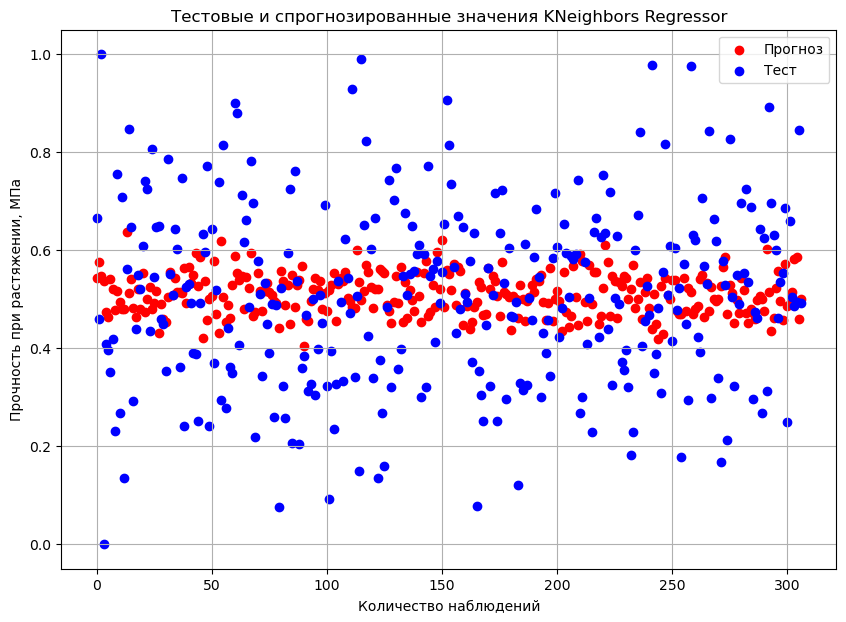

In [70]:
# визуализируем настоящие (отмечены синим цветом) и прогнозные значения (отмечены красным цветом)
plt.figure(figsize = (10, 7))
plt.title("Тестовые и спрогнозированные значения KNeighbors Regressor")
plt.scatter(y_pred.index, y_pred, label = "Прогноз", color = "r")
plt.scatter(y_scaled_test.index, y_scaled_test, label = "Тест", color = "b")
plt.xlabel("Количество наблюдений")
plt.ylabel("Прочность при растяжении, МПа")
plt.legend()
plt.grid(True);

In [71]:
# добавим в таблицу данные по этой модели
metrics_df.loc[len(metrics_df.index)] = ['KNeighbors Regressor', knn_rmse, knn_r2_score] 
metrics_df

,Регрессор,RMSE,r2 score
0,Linear_Regression,0.186273,-0.029695
1,Linear_Regression_sample_normalization,470.122198,-0.028440
2,Support Vector Regressor,0.204037,-0.235450
3,Support Vector Regressor_sample_normalization,463.729506,-0.000661
4,Random Forest Regressor,468.614005,-0.021852
5,KNeighbors Regressor,0.188264,-0.051825


Выводы:
- ни одна из использованных моделей не дала удовлетворительного результата;
- указанную ошибку трудно интерпретировать, так как она подсчитана на нормализованных разными способами данных;
- использовать другие регрессоры будет затратным по времени, но скорее всего не отразится на точности прогноза, как и раличные модификации этапа подготовки данных.

Попробуем подбор гиперпараметров и используем другой подход: ансамблевый метод градиентного бустинга. 
В классическом варианте метод больше подходит для классификации, 
но с аккуратным побдором гиперпараметров и с учетом, что остальные модели не подошли или по логике их работы точно не подойдут 
(например, лассо регрессор), попробуем прибегнуть к этому способу.

#### Gradient Boosting Regressor model

В машинном обучении гиперпараметрами называют параметры алгоритмов, значения которых устанавливаются перед запуском процесса обучения. 
Необходимо создать словарь для последующего подбора оптимальных значений по сетке.

In [73]:
# проверим датасет, который был сохранен ранее
df_x.head(3)

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,1.857143,2030.0,738.736842,36.513195,22.267857,178.163161,210.0,70.0,220.0,0.0,4.0,57.0
1,1.857143,2030.0,738.736842,50.000000,23.750000,284.615385,210.0,70.0,220.0,0.0,4.0,60.0
2,1.857143,2030.0,738.736842,49.900000,28.992783,284.615385,210.0,70.0,220.0,0.0,4.0,70.0


In [74]:
# сформируем набор значений зависимой переменной
df_y = df['Прочность при растяжении, МПа']
df_y.head(3)

0    3000.0
1    3000.0
2    3000.0
Name: Прочность при растяжении, МПа, dtype: float64

In [75]:
# разобъем наборы на тестовую и тренировочную выборки (на 30% и 70%, соответственно, по условиям задачи)
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, train_size=0.7, random_state=73)

In [76]:
# проверим размерность получившихся массивов 
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(716, 12)
(307, 12)
(716,)
(307,)


In [77]:
# создадим словарь для гиперпараметров будущей модели
parameters = {'n_estimators': [100, 300],
             'max_depth': [3, 5, 8], 'learning_rate': [0.01, 0.1],
              'subsample': [0.5, 1]}

In [78]:
# создаем экземпляр класса
gbr = GradientBoostingRegressor()

In [80]:
# проведем поиск по сетке с перекрестной проверкой, количество блоков равно 10 (cv = 10) по условию задачи
grid = GridSearchCV(estimator = gbr, param_grid = parameters, cv = 10, verbose = 1, scoring = 'r2')
grid.fit(x_train, y_train)
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
display(grid)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
Best parameters are: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 300, 'subsample': 0.5}


-0.006 + or -0.033 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
-0.025 + or -0.043 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}
-0.003 + or -0.053 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.5}
-0.035 + or -0.052 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1}
0.004 + or -0.031 for the {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.5}
-0.026 + or -0.047 for the {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}
-0.003 + or -0.057 for the {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.5}
-0.051 + or -0.07 for the {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 

In [81]:
# выведем лучшую модель
print(grid.best_estimator_)

GradientBoostingRegressor(learning_rate=0.01, max_depth=8, n_estimators=300,
                          subsample=0.5)


In [82]:
# подставим найденные гиперпараметры в модель
gbr = GradientBoostingRegressor(n_estimators=300, max_depth=8, learning_rate=0.01, subsample=0.5)
gbr.fit(x_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=8, n_estimators=300,
                          subsample=0.5)

In [83]:
# спрогнозируем значения прочности при растяжении
y_pred = gbr.predict(x_test)

In [84]:
# используем встроенные в библиотеку sklearn метрики для вычисления ошибки
gbr_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
gbr_r2_score = r2_score(y_test, y_pred)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', 
      np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('r2 score:', r2_score(y_test, y_pred))

Mean Absolute Error: 383.5066115615016
Mean Squared Error: 227601.86139792312
Root Mean Squared Error: 477.0763685175814
r2 score: -0.05909112802655758


In [85]:
# преобразуем массив в таблицу pandas
y_pred = pd.DataFrame(y_pred)
y_pred.head(3)

,0
0,2531.355633
1,2660.592714
2,2482.289166


In [86]:
# преобразуем массив тестовых данных в таблицу pandas
y_test = pd.DataFrame(y_test).reset_index(drop=True)
y_test.head(3)

,"Прочность при растяжении, МПа"
0,2868.713028
1,2350.243870
2,3714.207126


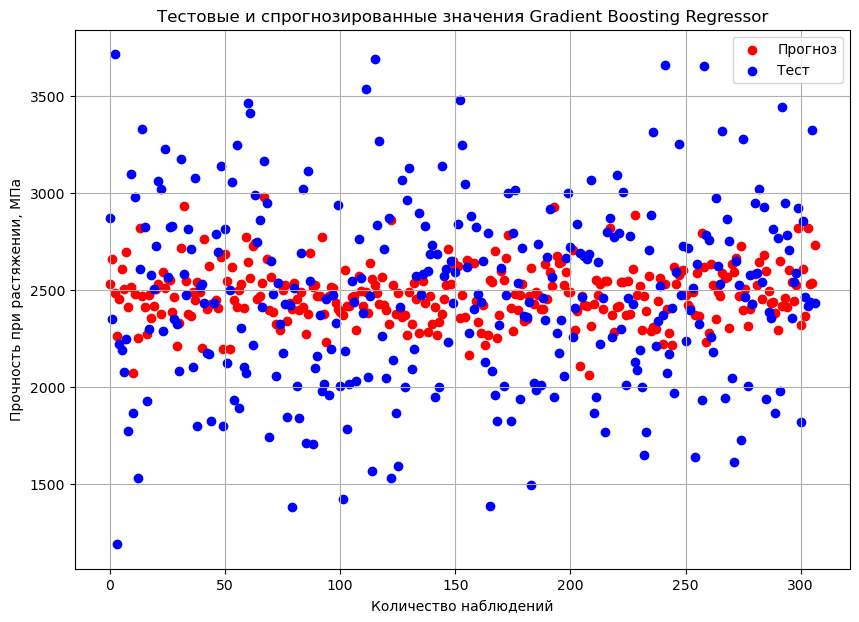

In [87]:
# визуализируем настоящие (отмечены синим цветом) и прогнозные значения (отмечены красным цветом)
plt.figure(figsize = (10, 7))
plt.title("Тестовые и спрогнозированные значения Gradient Boosting Regressor")
plt.scatter(y_pred.index, y_pred, label = "Прогноз", color = "r")
plt.scatter(y_test.index, y_test, label = "Тест", color = "b")
plt.xlabel("Количество наблюдений")
plt.ylabel("Прочность при растяжении, МПа")
plt.legend()
plt.grid(True);

In [88]:
# добавим в таблицу данные по этой модели
metrics_df.loc[len(metrics_df.index)] = ['Gradient Boosting Regressor', gbr_rmse, gbr_r2_score] 
metrics_df

,Регрессор,RMSE,r2 score
0,Linear_Regression,0.186273,-0.029695
1,Linear_Regression_sample_normalization,470.122198,-0.028440
2,Support Vector Regressor,0.204037,-0.235450
3,Support Vector Regressor_sample_normalization,463.729506,-0.000661
4,Random Forest Regressor,468.614005,-0.021852
5,KNeighbors Regressor,0.188264,-0.051825
6,Gradient Boosting Regressor,477.076369,-0.059091


#### Support Vector Regressor model (+GridSearch)

Попробуем подобрать гиперпараметры для визуально наиболее подходящего под задачу регрессора - Метод опорных векторов.

In [89]:
# будем использовать нормализованный с помощью MinMaxScaler() датасет
# разобъем наборы на тестовую и тренировочную выборки (на 30% и 70%, соответственно, по условиям задачи)
x_scaled_train, x_scaled_test, y_scaled_train, y_scaled_test = train_test_split(df_scaled_x, df_scaled_y, train_size=0.7, random_state=73)

In [90]:
# проверим размерность получившихся массивов 
print(x_scaled_train.shape)
print(x_scaled_test.shape)
print(y_scaled_train.shape)
print(y_scaled_test.shape)

(716, 12)
(307, 12)
(716, 1)
(307, 1)


In [91]:
# создадим словарь для гиперпараметров будущей модели
parameters = {'C': [30, 50, 100, 200],
             'gamma': ['scale', 'auto'], 'epsilon': [0.1, 0.3, 0.7, 1]}

In [92]:
# создадим экземпляр класса
svr = SVR()

In [93]:
# приведем массив значений зависимой переменной к нужному формату
y_scaled_train = y_scaled_train.ravel()
y_scaled_train[:3]

array([0.0298864 , 0.18716583, 0.34587697])

In [94]:
# проведем поиск по сетке с перекрестной проверкой, количество блоков равно 10 (cv = 10) по условию задачи
grid = GridSearchCV(estimator = svr, param_grid = parameters, cv = 10, verbose = 1, scoring = 'r2')
grid.fit(x_scaled_train, y_scaled_train)
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
display(grid)

Fitting 10 folds for each of 32 candidates, totalling 320 fits
Best parameters are: {'C': 30, 'epsilon': 0.7, 'gamma': 'scale'}


-0.931 + or -0.463 for the {'C': 30, 'epsilon': 0.1, 'gamma': 'scale'}
-0.077 + or -0.088 for the {'C': 30, 'epsilon': 0.1, 'gamma': 'auto'}
-0.214 + or -0.128 for the {'C': 30, 'epsilon': 0.3, 'gamma': 'scale'}
-0.065 + or -0.069 for the {'C': 30, 'epsilon': 0.3, 'gamma': 'auto'}
-0.013 + or -0.01 for the {'C': 30, 'epsilon': 0.7, 'gamma': 'scale'}
-0.013 + or -0.01 for the {'C': 30, 'epsilon': 0.7, 'gamma': 'auto'}
-0.013 + or -0.01 for the {'C': 30, 'epsilon': 1, 'gamma': 'scale'}
-0.013 + or -0.01 for the {'C': 30, 'epsilon': 1, 'gamma': 'auto'}
-0.965 + or -0.476 for the {'C': 50, 'epsilon': 0.1, 'gamma': 'scale'}
-0.097 + or -0.102 for the {'C': 50, 'epsilon': 0.1, 'gamma': 'auto'}
-0.214 + or -0.128 for the {'C': 50, 'epsilon': 0.3, 'gamma': 'scale'}
-0.101 + or -0.067 for the {'C': 50, 'epsilon': 0.3, 'gamma': 'auto'}
-0.013 + or -0.01 for the {'C': 

In [95]:
# выведем лучшую модель
print(grid.best_estimator_)

SVR(C=30, epsilon=0.7)


In [96]:
# обучим модель
svr = SVR(kernel = 'rbf', C = 30, epsilon= 0.7)
svr.fit(x_scaled_train, y_scaled_train)

SVR(C=30, epsilon=0.7)

In [97]:
# спрогнозируем значения прочности при растяжении
y_pred = svr.predict(x_scaled_test)

In [98]:
# используем встроенные в библиотеку sklearn метрики для вычисления ошибки
svr_rmse = np.sqrt(metrics.mean_squared_error(y_scaled_test, y_pred))
svr_r2_score = r2_score(y_scaled_test, y_pred)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_scaled_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_scaled_test, y_pred))
print('Root Mean Squared Error:', 
      np.sqrt(metrics.mean_squared_error(y_scaled_test, y_pred)))
print('r2 score:', r2_score(y_scaled_test, y_pred))

Mean Absolute Error: 0.1466442644592727
Mean Squared Error: 0.0337438037312827
Root Mean Squared Error: 0.18369486582722636
r2 score: -0.0013867160992497851


In [99]:
# преобразуем массив в таблицу pandas
y_pred = pd.DataFrame(y_pred)
y_pred.head(3)

,0
0,0.5
1,0.5
2,0.5


In [100]:
# преобразуем массив тестовых данных в таблицу pandas
y_scaled_test = pd.DataFrame(y_scaled_test)
y_scaled_test.head(3)

,0
0,0.665200
1,0.459896
2,1.000000


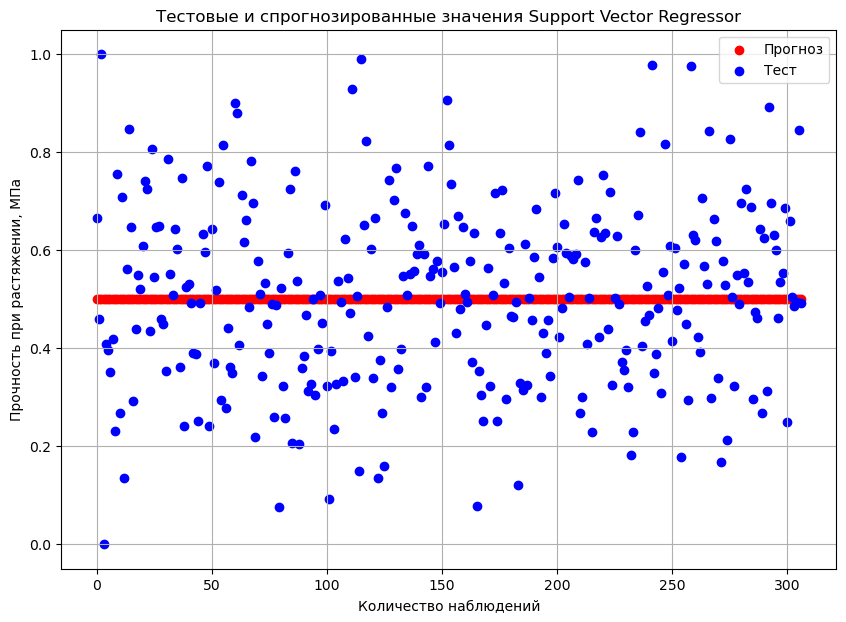

In [101]:
# визуализируем настоящие (отмечены синим цветом) и прогнозные значения (отмечены красным цветом)
plt.figure(figsize = (10, 7))
plt.title("Тестовые и спрогнозированные значения Support Vector Regressor")
plt.scatter(y_pred.index, y_pred, label = "Прогноз", color = "r")
plt.scatter(y_scaled_test.index, y_scaled_test, label = "Тест", color = "b")
plt.xlabel("Количество наблюдений")
plt.ylabel("Прочность при растяжении, МПа")
plt.legend()
plt.grid(True);

In [102]:
# добавим в таблицу данные по этой модели
metrics_df.loc[len(metrics_df.index)] = ['Support Vector Regressor + GridSearch', svr_rmse, svr_r2_score] 
metrics_df

,Регрессор,RMSE,r2 score
0,Linear_Regression,0.186273,-0.029695
1,Linear_Regression_sample_normalization,470.122198,-0.028440
2,Support Vector Regressor,0.204037,-0.235450
3,Support Vector Regressor_sample_normalization,463.729506,-0.000661
4,Random Forest Regressor,468.614005,-0.021852
5,KNeighbors Regressor,0.188264,-0.051825
6,Gradient Boosting Regressor,477.076369,-0.059091
7,Support Vector Regressor + GridSearch,0.183695,-0.001387


**Заключение**: ни одной из моделей, даже при подборе гиперпарамтеров и различных способах подготовки данных, не удалось обучиться. 

Вероятно, написание нейронной сети помогло бы решить данную задачу. 

Тем не менее, в процессе создания множества вариантов моделей обнаружен способ повышения точности прогноза: использование зависимой переменной для расчета L2 нормы при нормализации. При этом при обучении используются неизмененные значения зависимой переменной. Точность такого прогноза повышается до 0.96. Однако, наиболее вероятно, что такая модель не способона на экстраполяции и покажет плохую работу в продакшн из-за некорректного расчета значений векторов при нормализации.
Приведем ниже вычисления и результаты прогноза для наглядности.

In [172]:
# загрузим датасет, нормализованным по рядам таблицы
df_norm = pd.read_csv('/Users/kusita_1/Desktop/df compositum norm.csv', index_col=0)
df_norm.head(3)

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,0.000500,0.546440,0.198855,0.009829,0.005994,0.047958,0.056528,0.018843,0.807547,0.059220,0.0,0.001077,0.015343
1,0.000499,0.545436,0.198490,0.013434,0.006381,0.076473,0.056424,0.018808,0.806064,0.059111,0.0,0.001075,0.016121
2,0.000499,0.545406,0.198478,0.013407,0.007790,0.076468,0.056421,0.018807,0.806018,0.059108,0.0,0.001075,0.018807


In [173]:
# разобъем наборы на тестовую и тренировочную выборки (на 30% и 70%, соответственно, по условиям задачи)
df_norm_y = df_norm[['Прочность при растяжении, МПа']]
df_norm_x = df_norm.drop('Прочность при растяжении, МПа', axis=1)
x_norm_train, x_norm_test, y_norm_train, y_norm_test = train_test_split(df_norm_x, df_norm_y, train_size=0.7, random_state=73)

In [105]:
# обучим модель
lr = LinearRegression()
lr.fit(x_norm_train, y_norm_train)

LinearRegression()

In [106]:
# спрогнозируем значения 
y_pred = lr.predict(x_norm_test)

In [107]:
# используем встроенные в библиотеку sklearn метрики для вычисления ошибки
lr_norm_rmse = np.sqrt(metrics.mean_squared_error(y_norm_test, y_pred))
lr_norm_r2_score = r2_score(y_norm_test, y_pred)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_norm_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_norm_test, y_pred))
print('Root Mean Squared Error:', 
      np.sqrt(metrics.mean_squared_error(y_norm_test, y_pred)))
print('r2 score:', r2_score(y_norm_test, y_pred))

Mean Absolute Error: 0.010792910210592227
Mean Squared Error: 0.00021158973437819507
Root Mean Squared Error: 0.01454612437655457
r2 score: 0.9551137433659668


In [108]:
# преобразуем массив в таблицу pandas
y_pred = pd.DataFrame(y_pred)
y_pred.head(3)

,0
0,0.779742
1,0.707121
2,0.852702


In [109]:
# преобразуем массив тестовых данных в таблицу pandas
y_norm_test = pd.DataFrame(y_norm_test).reset_index(drop=True)
y_norm_test.head(3)

,"Прочность при растяжении, МПа"
0,0.783523
1,0.721566
2,0.839206


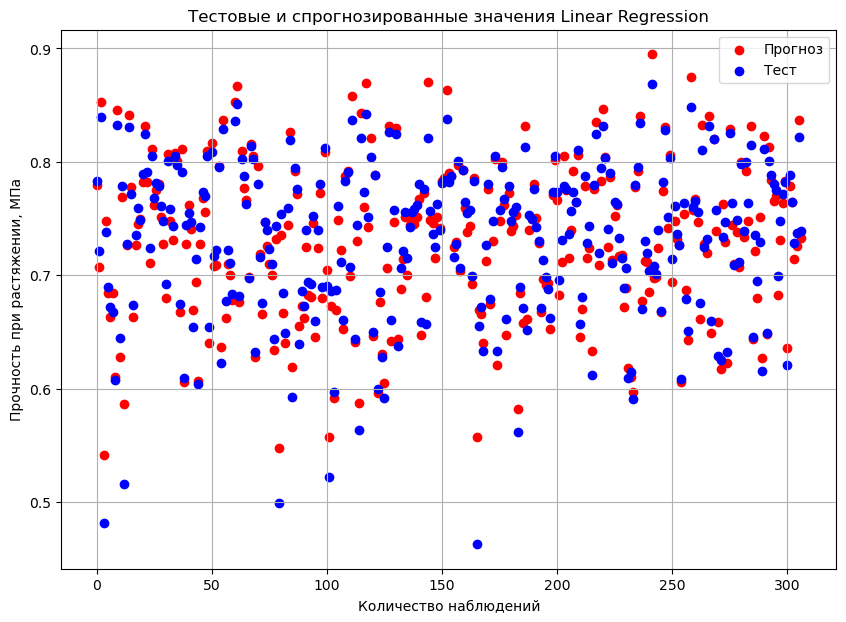

In [110]:
# визуализируем настоящие (отмечены синим цветом) и прогнозные значения (отмечены красным цветом)
y_pred = pd.DataFrame(y_pred)
y_norm_test = pd.DataFrame(y_norm_test)
plt.figure(figsize = (10, 7))
plt.title("Тестовые и спрогнозированные значения Linear Regression")
plt.scatter(y_pred.index, y_pred, label = "Прогноз", color = "r")
plt.scatter(y_norm_test.index, y_norm_test, label = "Тест", color = "b")
plt.xlabel("Количество наблюдений")
plt.ylabel("Прочность при растяжении, МПа")
plt.legend()
plt.grid(True);

### Прогнозирование соотношения матрица-наполнитель

Задача: написание нейронной сети, которая будет рекомендовать соотношение матрица-наполнитель.

In [4]:
# возьмем датасет, получившийся после работы с выбросами
# выделим отдельно зависимую и незаивисмые переменные
df_tensor_x = df.drop('Соотношение матрица-наполнитель', axis=1)
df_tensor_y = df['Соотношение матрица-наполнитель']

In [5]:
# посмотрим на верхние 3 ряда датасета с предикторами
df_tensor_x.head(3)

,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,2030.0,738.736842,36.513195,22.267857,178.163161,210.0,70.0,3000.0,220.0,0.0,4.0,57.0
1,2030.0,738.736842,50.000000,23.750000,284.615385,210.0,70.0,3000.0,220.0,0.0,4.0,60.0
2,2030.0,738.736842,49.900000,28.992783,284.615385,210.0,70.0,3000.0,220.0,0.0,4.0,70.0


In [6]:
# посмотрим на верхние 3 ряда набора значений зависимой переменной - "Соотношение матрица-наполнитель"
df_tensor_y.head(3)

0    1.857143
1    1.857143
2    1.857143
Name: Соотношение матрица-наполнитель, dtype: float64

In [7]:
# разобьем данные на тренировочный и тестовый наборы в количестве 70% и 30%, соответственно, по условию задачи
x_train, x_test, y_train, y_test = train_test_split(df_tensor_x, df_tensor_y, test_size=0.3, random_state=73)

In [9]:
# проведем нормализацию данных с применением специального слоя библиотеки keras
normalizer_layer = tf.keras.layers.Normalization(axis=1)
normalizer_layer.adapt(np.array(df_tensor_x).astype('float32'))

In [10]:
# посмотрим на получившиеся средние значения переменных
normalizer_layer.mean.numpy()

array([[1975.6876   ,  739.5141   ,  110.565285 ,   22.241764 ,
         285.9502   ,  482.6098   ,   73.32708  , 2466.8508   ,
         218.3893   ,   44.252197 ,    6.8977365,   57.204575 ]],
      dtype=float32)

In [11]:
# посмотрим на средние значения этих же переменных исходного датасета
df_tensor_x.describe().T[['mean', 'std']]

,mean,std
"Плотность, кг/м3",1975.687974,73.123013
"модуль упругости, ГПа",739.514160,328.958381
"Количество отвердителя, м.%",110.565286,28.054043
"Содержание эпоксидных групп,%_2",22.241765,2.388029
"Температура вспышки, С_2",285.950171,40.496196
"Поверхностная плотность, г/м2",482.609742,280.931465
"Модуль упругости при растяжении, ГПа",73.327066,3.107119
"Прочность при растяжении, МПа",2466.850794,483.526260
"Потребление смолы, г/м2",218.389298,59.305822
"Угол нашивки, град",44.252199,45.015793


Вывод: нормализация прошла успешно: средние значения, полученные в результате нормализации практически совпадают со средними в оригинальной таблице.

In [12]:
# установим seed для воспроизводимости
seed = 7
np.random.seed(seed)
tf.random.set_seed(seed)
# формирование модели
# рассчитаем количество необходимых нейронов в скрытом слое по теореме Хехт-Нильсена, функцию активации выберем по аналогии с успешными прогнозами других работ по регрессии
model = Sequential()
model.add(normalizer_layer)
model.add(Dense(8, activation='relu'))
model.add(Dense(17, activation='relu'))
# выходной слой
model.add(Dense(1, activation='relu'))
# компилирование модели
model.compile(optimizer=tf.optimizers.legacy.SGD(), loss='mean_absolute_error')  

In [13]:
# выведем архитектуру модели
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 12)               25        
 ion)                                                            
                                                                 
 dense (Dense)               (None, 8)                 104       
                                                                 
 dense_1 (Dense)             (None, 17)                153       
                                                                 
 dense_2 (Dense)             (None, 1)                 18        
                                                                 
Total params: 300
Trainable params: 275
Non-trainable params: 25
_________________________________________________________________


Epoch 1/30
3/3 [==============================] - 0s 55ms/step - loss: 2.5084 - val_loss: 2.3559
Epoch 2/30
3/3 [==============================] - 0s 9ms/step - loss: 2.4015 - val_loss: 2.2386
Epoch 3/30
3/3 [==============================] - 0s 9ms/step - loss: 2.2852 - val_loss: 2.1114
Epoch 4/30
3/3 [==============================] - 0s 10ms/step - loss: 2.1617 - val_loss: 1.9836
Epoch 5/30
3/3 [==============================] - 0s 10ms/step - loss: 2.0383 - val_loss: 1.8608
Epoch 6/30
3/3 [==============================] - 0s 10ms/step - loss: 1.9156 - val_loss: 1.7400
Epoch 7/30
3/3 [==============================] - 0s 9ms/step - loss: 1.7965 - val_loss: 1.6283
Epoch 8/30
3/3 [==============================] - 0s 9ms/step - loss: 1.6879 - val_loss: 1.5220
Epoch 9/30
3/3 [==============================] - 0s 10ms/step - loss: 1.5885 - val_loss: 1.4203
Epoch 10/30
3/3 [==============================] - 0s 9ms/step - loss: 1.4918 - val_loss: 1.3283
Epoch 11/30
3/3 [=================

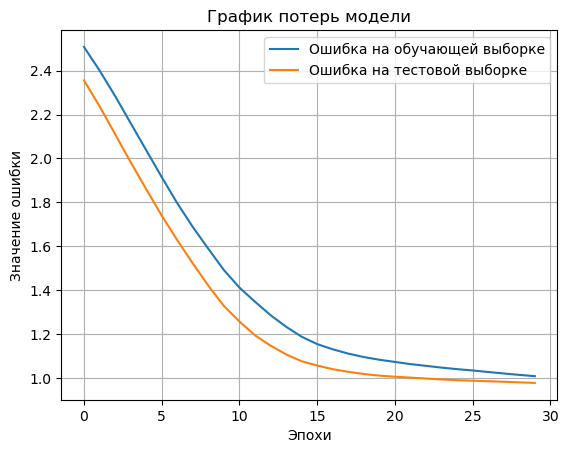

CPU times: user 2.25 s, sys: 467 ms, total: 2.72 s
Wall time: 1.55 s


In [14]:
%%time
# обучение модели
history = model.fit(x_train, y_train, batch_size=250, epochs=30, validation_split=0.2)
# визуализация процесса обучения (график потерь на тренировочной и тестовой выборках)
def plot_loss(history):
    plt.plot(history.history['loss'], label = 'ошибка на обучающей выборке')
    plt.plot(history.history['val_loss'], label = 'ошибка на тестовой выборке')
    plt.title('График потерь модели')
    plt.xlabel('Эпохи')
    plt.ylabel('Значение ошибки')
    plt.legend(["Ошибка на обучающей выборке", "Ошибка на тестовой выборке"])
    plt.grid(True)

plot_loss(history)
plt.show()

In [15]:
# посмотрим на потери модели
history = pd.DataFrame(history.history)
history.tail()

,loss,val_loss
25,1.034070,0.987370
26,1.027245,0.985185
27,1.020354,0.982597
28,1.014077,0.980018
29,1.008223,0.977409


In [16]:
# создадим словарь для фиксации ошибки модели
test_results = {}
test_results['model_8/17/1'] = model.evaluate(x_test, y_test, verbose=0)

In [17]:
test_results

{'model_8/17/1': 0.9628087282180786}

In [18]:
# выведем в табличном виде ошибку модели
pd.DataFrame(test_results, index=['MAE [Соотношение матрица-наполнитель]']).T

,MAE [Соотношение матрица-наполнитель]
model_8/17/1,0.962809


In [19]:
# осуществим прогноз 
predictions = model.predict(x_test.astype(np.float32))

10/10 [==============================] - 0s 620us/step


In [20]:
# выведем результаты работы модели
print('Model Results:')
print('Model_MAE: ', round(metrics.mean_absolute_error(y_test, predictions)))
print('Model_MAPE: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_test, predictions)))
print("Test score: {:.2f}".format(metrics.mean_squared_error(y_test, predictions)))

Model Results:
Model_MAE:  1
Model_MAPE: 0.38
Test score: 1.44


In [21]:
# приведем к табличному виду массив с тестовыми значениями зависимой переменной 
y_test = pd.DataFrame(y_test).reset_index(drop=True)
y_test.head(3)

,Соотношение матрица-наполнитель
0,3.405932
1,1.512672
2,2.334566


In [22]:
# приведем к табличному виду массив с прогнозными значениями
predictions = pd.DataFrame(predictions)
predictions.head(3)

,0
0,3.039660
1,2.764719
2,5.331261


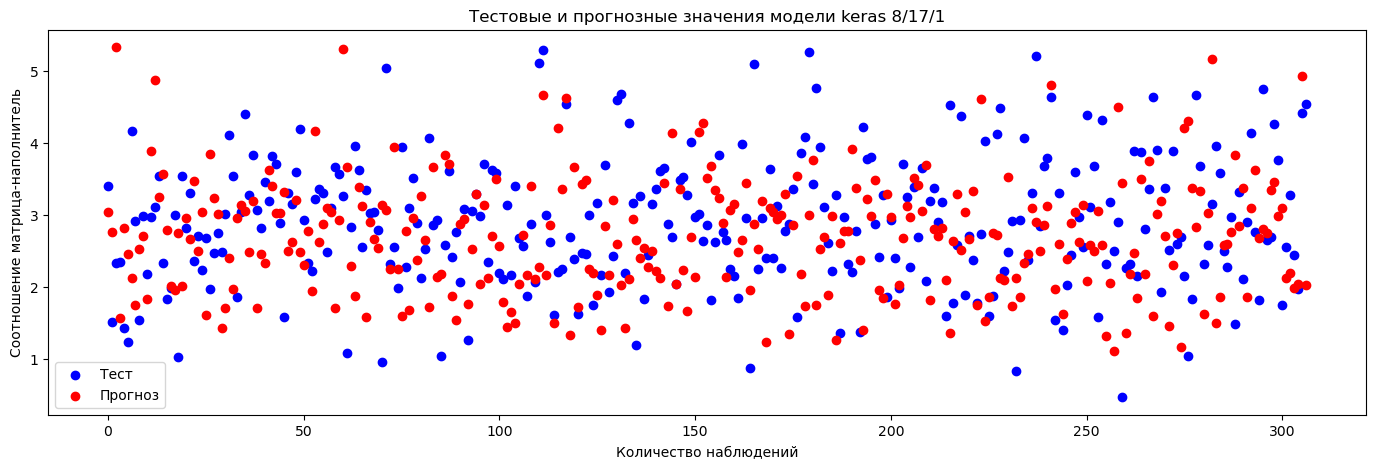

In [23]:
# визуализируем тестовые и прогнозные значения
plt.figure(figsize=(17,5))
plt.title('Тестовые и прогнозные значения модели keras 8/17/1')
plt.scatter(y_test.index, y_test, label = 'Тест', color='b')
plt.scatter(predictions.index, predictions, label = 'Прогноз', color='r')
plt.legend(loc = 'best')
plt.ylabel('Соотношение матрица-наполнитель')
plt.xlabel('Количество наблюдений')
plt.show()

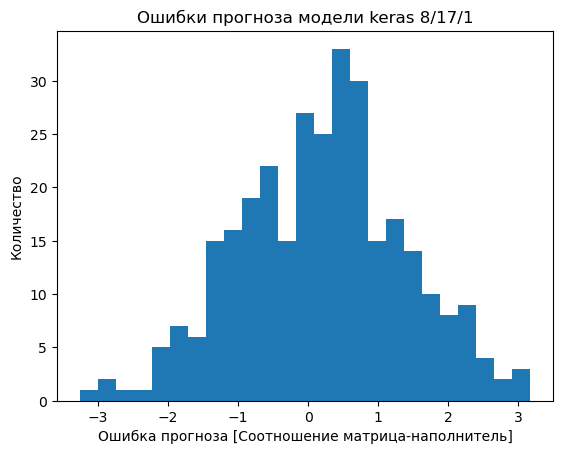

In [24]:
# визуализируем ошибки модели
error = np.array(y_test) - np.array(predictions)
plt.hist(error, bins=25)
plt.title('Ошибки прогноза модели keras 8/17/1')
plt.xlabel('Ошибка прогноза [Соотношение матрица-наполнитель]')
_ = plt.ylabel('Количество')

In [25]:
# попробуем улучшить прогноз, увеличив количество нейронов
# установим seed для воспроизводимости
seed = 7
np.random.seed(seed)
tf.random.set_seed(seed)
# формирование модели
# рассчитаем количество необходимых нейронов в скрытом слое по теореме Хехт-Нильсена, функцию активации выберем по аналогии с успешными прогнозами других работ по регрессии
model_16 = Sequential()
model_16.add(normalizer_layer)
model_16.add(Dense(16, activation='relu'))
model_16.add(Dense(33, activation='relu'))
# выходной слой
model_16.add(Dense(1, activation='relu'))
# компилирование модели
model_16.compile(optimizer=tf.optimizers.legacy.SGD(), loss='mean_absolute_error')  

In [26]:
# выведем архитектуру модели
model_16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 12)               25        
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 16)                208       
                                                                 
 dense_4 (Dense)             (None, 33)                561       
                                                                 
 dense_5 (Dense)             (None, 1)                 34        
                                                                 
Total params: 828
Trainable params: 803
Non-trainable params: 25
_________________________________________________________________


Epoch 1/50
3/3 [==============================] - 0s 48ms/step - loss: 2.8909 - val_loss: 2.8381
Epoch 2/50
3/3 [==============================] - 0s 9ms/step - loss: 2.8748 - val_loss: 2.8181
Epoch 3/50
3/3 [==============================] - 0s 9ms/step - loss: 2.8534 - val_loss: 2.7933
Epoch 4/50
3/3 [==============================] - 0s 10ms/step - loss: 2.8257 - val_loss: 2.7604
Epoch 5/50
3/3 [==============================] - 0s 10ms/step - loss: 2.7879 - val_loss: 2.7200
Epoch 6/50
3/3 [==============================] - 0s 12ms/step - loss: 2.7402 - val_loss: 2.6673
Epoch 7/50
3/3 [==============================] - 0s 10ms/step - loss: 2.6823 - val_loss: 2.6056
Epoch 8/50
3/3 [==============================] - 0s 10ms/step - loss: 2.6136 - val_loss: 2.5262
Epoch 9/50
3/3 [==============================] - 0s 11ms/step - loss: 2.5231 - val_loss: 2.4276
Epoch 10/50
3/3 [==============================] - 0s 10ms/step - loss: 2.4173 - val_loss: 2.3132
Epoch 11/50
3/3 [==============

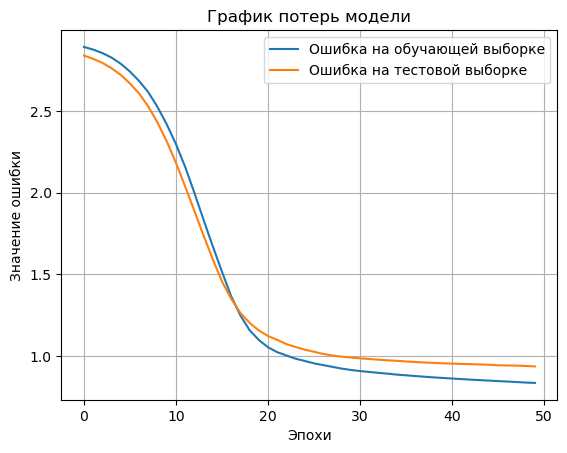

CPU times: user 2.11 s, sys: 226 ms, total: 2.33 s
Wall time: 2.19 s


In [27]:
%%time
# обучение модели, увеличим количество эпох обучения с учетом увеличения количества нейронов
history = model_16.fit(x_train, y_train, batch_size=250, epochs=50, validation_split=0.2)
# визуализация процесса обучения (график потерь на тренировочной и тестовой выборках)
def plot_loss(history):
    plt.plot(history.history['loss'], label = 'ошибка на обучающей выборке')
    plt.plot(history.history['val_loss'], label = 'ошибка на тестовой выборке')
    plt.title('График потерь модели')
    plt.xlabel('Эпохи')
    plt.ylabel('Значение ошибки')
    plt.legend(["Ошибка на обучающей выборке", "Ошибка на тестовой выборке"])
    plt.grid(True)

plot_loss(history)
plt.show()

In [28]:
# создание директории для сохранения модели
!mkdir -p saved_model

In [29]:
# сохранение модели
model_16.save('saved_model/composites_model_16')

INFO:tensorflow:Assets written to: saved_model/composites_model_16/assets


In [31]:
# выполним загрузку модели
model_16 = tf.keras.models.load_model("saved_model/composites_model_16/")

In [32]:
# проверяем архитектуру модели
model_16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 12)               25        
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 16)                208       
                                                                 
 dense_4 (Dense)             (None, 33)                561       
                                                                 
 dense_5 (Dense)             (None, 1)                 34        
                                                                 
Total params: 828
Trainable params: 803
Non-trainable params: 25
_________________________________________________________________


In [33]:
# посмотрим на потери модели
history = pd.DataFrame(history.history)
history.tail()

,loss,val_loss
45,0.848168,0.944710
46,0.845446,0.943807
47,0.842348,0.942833
48,0.839287,0.940648
49,0.836998,0.937772


In [34]:
# добавим в словарь результаты оценки работы модели
test_results['model_16/33/1'] = model_16.evaluate(x_test, y_test, verbose=0)

In [35]:
# выведем в табличном виде ошибки моделей
pd.DataFrame(test_results, index=['MAE [Соотношение матрица-наполнитель]']).T

,MAE [Соотношение матрица-наполнитель]
model_8/17/1,0.962809
model_16/33/1,0.830088


In [36]:
# осуществим прогноз 
predictions = model_16.predict(x_test.astype(np.float32))

10/10 [==============================] - 0s 620us/step


In [37]:
# выведем результаты работы модели
print('Model Results:')
print('Model_MAE: ', round(metrics.mean_absolute_error(y_test, predictions)))
print('Model_MAPE: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_test, predictions)))
print("Test score: {:.2f}".format(metrics.mean_squared_error(y_test, predictions)))

Model Results:
Model_MAE:  1
Model_MAPE: 0.36
Test score: 1.10


In [38]:
# приведем к табличному виду массив с тестовыми значениями зависимой переменной 
y_test = pd.DataFrame(y_test).reset_index(drop=True)
y_test.head(3)

,Соотношение матрица-наполнитель
0,3.405932
1,1.512672
2,2.334566


In [39]:
# приведем к табличному виду массив с прогнозными значениями
predictions = pd.DataFrame(predictions)
predictions.head(3)

,0
0,2.705141
1,3.567234
2,2.424339


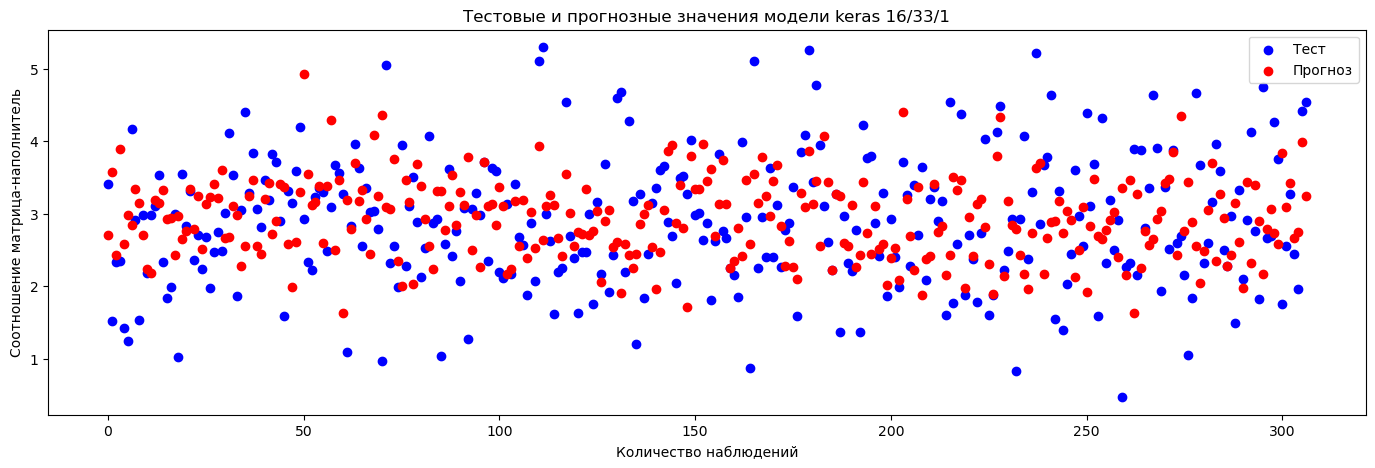

In [40]:
# визуализируем тестовые и прогнозные значения
plt.figure(figsize=(17,5))
plt.title('Тестовые и прогнозные значения модели keras 16/33/1')
plt.scatter(y_test.index, y_test, label = 'Тест', color='b')
plt.scatter(predictions.index, predictions, label = 'Прогноз', color='r')
plt.legend(loc = 'best')
plt.ylabel('Соотношение матрица-наполнитель')
plt.xlabel('Количество наблюдений')
plt.show()

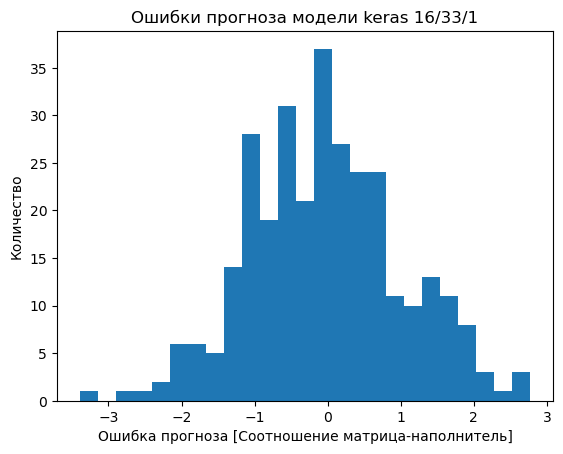

In [41]:
# визуализируем ошибки модели
error = np.array(y_test) - np.array(predictions)
plt.hist(error, bins=25)
plt.title('Ошибки прогноза модели keras 16/33/1')
plt.xlabel('Ошибка прогноза [Соотношение матрица-наполнитель]')
_ = plt.ylabel('Количество')

Выводы:
- нейронная сеть даже в самом простом исполнении позволила осуществить вполне адекватный прогноз;
- увеличение количества нейронов привело к повышению точности прогноза, что особенно очевидно при визуализации гистограммы ошибок;
- увеличение количества нейронов во входном слое в два раза позволило снизить среднюю абсолютную процентную ошибку прогнозирования всего на 0.02%, а среднюю абсолютную ошибку на 0.1, что при значительном увеличении количества ресурсов на обучение, нецелесообразно.

При увеличении количества эпох обучения наблюдалось повышение ошибки на тестовой выборке, что свидетельствовало о переобучении модели. 
Попробуем добавить слой, препятствующий переобучению.

In [43]:
# установим seed для воспроизводимости
seed = 7
np.random.seed(seed)
tf.random.set_seed(seed)
# формирование модели
# рассчитаем количество необходимых нейронов в скрытом слое по теореме Хехт-Нильсена, функцию активации выберем по аналогии с успешными прогнозами других работ по регрессии
model_16_Drop = Sequential()
model_16_Drop.add(normalizer_layer)
model_16_Drop.add(Dense(16, activation='relu'))
model_16_Drop.add(Dropout(0.3))
model_16_Drop.add(Dense(33, activation='relu'))
model_16_Drop.add(Dropout(0.3))
# выходной слой
model_16_Drop.add(Dense(1, activation='relu'))
# компилирование модели
model_16_Drop.compile(optimizer=tf.optimizers.legacy.SGD(), loss='mean_absolute_error')

Epoch 1/150
3/3 [==============================] - 0s 50ms/step - loss: 2.3545 - val_loss: 2.2372
Epoch 2/150
3/3 [==============================] - 0s 10ms/step - loss: 2.2323 - val_loss: 2.0906
Epoch 3/150
3/3 [==============================] - 0s 10ms/step - loss: 2.1436 - val_loss: 1.9299
Epoch 4/150
3/3 [==============================] - 0s 10ms/step - loss: 1.9900 - val_loss: 1.7755
Epoch 5/150
3/3 [==============================] - 0s 10ms/step - loss: 1.8607 - val_loss: 1.6534
Epoch 6/150
3/3 [==============================] - 0s 10ms/step - loss: 1.7608 - val_loss: 1.5424
Epoch 7/150
3/3 [==============================] - 0s 11ms/step - loss: 1.6501 - val_loss: 1.4552
Epoch 8/150
3/3 [==============================] - 0s 11ms/step - loss: 1.5789 - val_loss: 1.3734
Epoch 9/150
3/3 [==============================] - 0s 10ms/step - loss: 1.5187 - val_loss: 1.3163
Epoch 10/150
3/3 [==============================] - 0s 11ms/step - loss: 1.5144 - val_loss: 1.2561
Epoch 11/150
3/3 [=

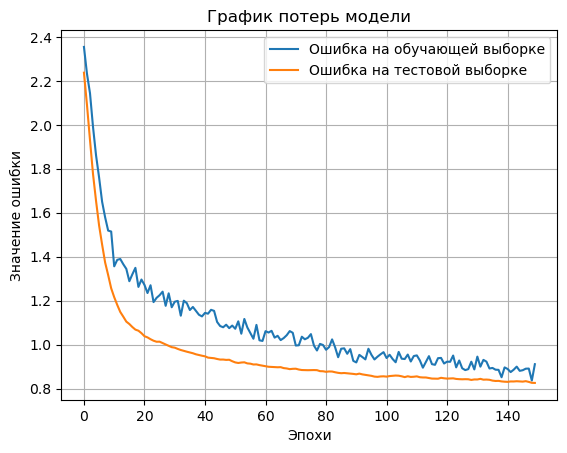

CPU times: user 4.05 s, sys: 430 ms, total: 4.48 s
Wall time: 4.03 s


In [44]:
%%time
# обучение модели, увеличим количество эпох обучения с учетом появления двух слоев
history = model_16_Drop.fit(x_train, y_train, batch_size=250, epochs=150, validation_split=0.2)
# визуализация процесса обучения (график потерь на тренировочной и тестовой выборках)
def plot_loss(history):
    plt.plot(history.history['loss'], label = 'ошибка на обучающей выборке')
    plt.plot(history.history['val_loss'], label = 'ошибка на тестовой выборке')
    plt.title('График потерь модели')
    plt.xlabel('Эпохи')
    plt.ylabel('Значение ошибки')
    plt.legend(["Ошибка на обучающей выборке", "Ошибка на тестовой выборке"])
    plt.grid(True)

plot_loss(history)
plt.show()

In [45]:
# сохраним также эту модель
model_16_Drop.save('saved_model/composites_16_Drop')

INFO:tensorflow:Assets written to: saved_model/composites_16_Drop/assets


In [46]:
# проверим содержимое директории saved_model
ls saved_model

composites_16_Drop/  composites_model_16/


In [47]:
# выполним загрузку модели
model_16_Drop = tf.keras.models.load_model("saved_model/composites_16_Drop/")

In [48]:
# проверим архитектуру модели
model_16_Drop.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 12)               25        
 ion)                                                            
                                                                 
 dense_9 (Dense)             (None, 16)                208       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_10 (Dense)            (None, 33)                561       
                                                                 
 dropout_3 (Dropout)         (None, 33)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 34        
                                                      

In [49]:
# посмотрим на потери модели
history = pd.DataFrame(history.history)
history.tail()

,loss,val_loss
145,0.883355,0.831426
146,0.890307,0.833499
147,0.890798,0.830085
148,0.836188,0.825878
149,0.910679,0.825478


In [50]:
# добавим в словарь результаты оценки работы модели
test_results['model_16/Dropout/33/Dropout/1'] = model_16_Drop.evaluate(x_test, y_test, verbose=0)

In [51]:
# выведем в табличном виде ошибки моделей
pd.DataFrame(test_results, index=['MAE [Соотношение матрица-наполнитель]']).T

,MAE [Соотношение матрица-наполнитель]
model_8/17/1,0.962809
model_16/33/1,0.830088
model_16/Dropout/33/Dropout/1,0.773735


In [52]:
# осуществим прогноз 
predictions = model_16_Drop.predict(x_test.astype(np.float32))

10/10 [==============================] - 0s 656us/step


In [53]:
# выведем результаты работы модели
print('Model Results:')
print('Model_MAE: ', round(metrics.mean_absolute_error(y_test, predictions)))
print('Model_MAPE: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_test, predictions)))
print("Test score: {:.2f}".format(metrics.mean_squared_error(y_test, predictions)))

Model Results:
Model_MAE:  1
Model_MAPE: 0.31
Test score: 0.94


In [54]:
# приведем к табличному виду массив с тестовыми значениями зависимой переменной 
y_test = pd.DataFrame(y_test).reset_index(drop=True)
y_test.head(3)

,Соотношение матрица-наполнитель
0,3.405932
1,1.512672
2,2.334566


In [55]:
# приведем к табличному виду массив с прогнозными значениями
predictions = pd.DataFrame(predictions)
predictions.head(3)

,0
0,2.302426
1,3.005409
2,3.179095


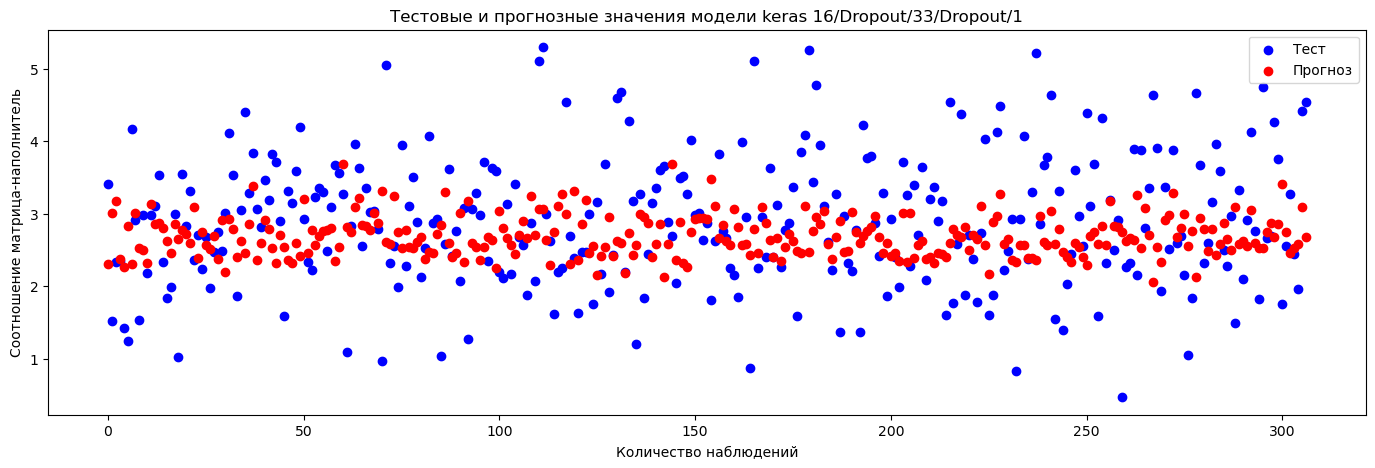

In [56]:
# визуализируем тестовые и прогнозные значения
plt.figure(figsize=(17,5))
plt.title('Тестовые и прогнозные значения модели keras 16/Dropout/33/Dropout/1')
plt.scatter(y_test.index, y_test, label = 'Тест', color='b')
plt.scatter(predictions.index, predictions, label = 'Прогноз', color='r')
plt.legend(loc = 'best')
plt.ylabel('Соотношение матрица-наполнитель')
plt.xlabel('Количество наблюдений')
plt.show()

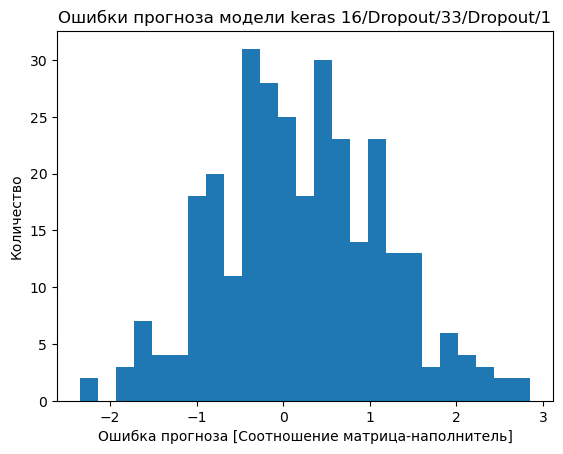

In [57]:
# визуализируем ошибки модели
error = np.array(y_test) - np.array(predictions)
plt.hist(error, bins=25)
plt.title('Ошибки прогноза модели keras 16/Dropout/33/Dropout/1')
plt.xlabel('Ошибка прогноза [Соотношение матрица-наполнитель]')
_ = plt.ylabel('Количество')

Попробуем изменить оптимизатор на тот, что на практике чаще показаывает хорошие результаты.

In [58]:
# установим seed для воспроизводимости
seed = 7
np.random.seed(seed)
tf.random.set_seed(seed)
# формирование модели
# рассчитаем количество необходимых нейронов в скрытом слое по теореме Хехт-Нильсена, функцию активации выберем по аналогии с успешными прогнозами других работ по регрессии
model_16_adam = Sequential()
model_16_adam.add(normalizer_layer)
model_16_adam.add(Dense(16, activation='relu'))
model_16_adam.add(Dropout(0.3))
model_16_adam.add(Dense(33, activation='relu'))
model_16_adam.add(Dropout(0.3))
# выходной слой
model_16_adam.add(Dense(1, activation='relu'))
# компилирование модели
model_16_adam.compile(optimizer=tf.optimizers.legacy.Adam(), loss='mean_absolute_error')

Epoch 1/250
3/3 [==============================] - 0s 56ms/step - loss: 2.3305 - val_loss: 2.3714
Epoch 2/250
3/3 [==============================] - 0s 10ms/step - loss: 2.2873 - val_loss: 2.2621
Epoch 3/250
3/3 [==============================] - 0s 10ms/step - loss: 2.1554 - val_loss: 2.1505
Epoch 4/250
3/3 [==============================] - 0s 12ms/step - loss: 2.1052 - val_loss: 2.0371
Epoch 5/250
3/3 [==============================] - 0s 11ms/step - loss: 1.9913 - val_loss: 1.9264
Epoch 6/250
3/3 [==============================] - 0s 11ms/step - loss: 1.8981 - val_loss: 1.8221
Epoch 7/250
3/3 [==============================] - 0s 14ms/step - loss: 1.8407 - val_loss: 1.7253
Epoch 8/250
3/3 [==============================] - 0s 10ms/step - loss: 1.7381 - val_loss: 1.6335
Epoch 9/250
3/3 [==============================] - 0s 10ms/step - loss: 1.6507 - val_loss: 1.5471
Epoch 10/250
3/3 [==============================] - 0s 11ms/step - loss: 1.5258 - val_loss: 1.4705
Epoch 11/250
3/3 [=

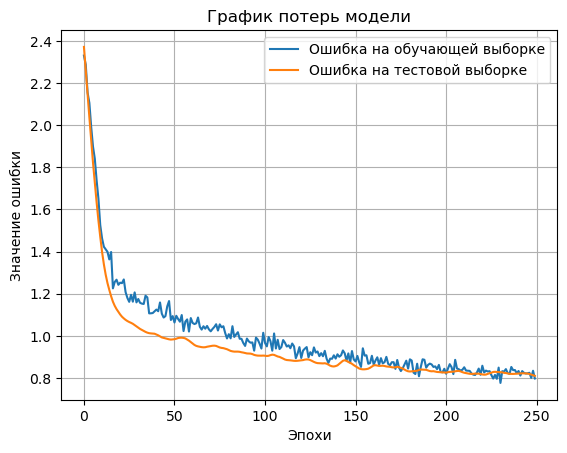

CPU times: user 6.31 s, sys: 733 ms, total: 7.04 s
Wall time: 6.26 s


In [59]:
%%time
# обучение модели, увеличим количество эпох обучения с учетом появления двух слоев
history = model_16_adam.fit(x_train, y_train, batch_size=250, epochs=250, validation_split=0.2)
# визуализация процесса обучения (график потерь на тренировочной и тестовой выборках)
def plot_loss(history):
    plt.plot(history.history['loss'], label = 'ошибка на обучающей выборке')
    plt.plot(history.history['val_loss'], label = 'ошибка на тестовой выборке')
    plt.title('График потерь модели')
    plt.xlabel('Эпохи')
    plt.ylabel('Значение ошибки')
    plt.legend(["Ошибка на обучающей выборке", "Ошибка на тестовой выборке"])
    plt.grid(True)

plot_loss(history)
plt.show()

In [60]:
# посмотрим на потери модели
history = pd.DataFrame(history.history)
history.tail()

,loss,val_loss
245,0.822627,0.821366
246,0.825104,0.819559
247,0.800771,0.816566
248,0.834826,0.813075
249,0.798172,0.810720


In [61]:
# добавим в словарь результаты оценки работы модели
test_results['model_16/Dropout/33/Dropout/1_Adam_opt'] = model_16_adam.evaluate(x_test, y_test, verbose=0)

In [62]:
# выведем в табличном виде ошибки моделей
pd.DataFrame(test_results, index=['MAE [Соотношение матрица-наполнитель]']).T

,MAE [Соотношение матрица-наполнитель]
model_8/17/1,0.962809
model_16/33/1,0.830088
model_16/Dropout/33/Dropout/1,0.773735
model_16/Dropout/33/Dropout/1_Adam_opt,0.739763


In [63]:
# осуществим прогноз 
predictions = model_16_adam.predict(x_test.astype(np.float32))

10/10 [==============================] - 0s 632us/step


In [64]:
# выведем результаты работы модели
print('Model Results:')
print('Model_MAE: ', round(metrics.mean_absolute_error(y_test, predictions)))
print('Model_MAPE: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_test, predictions)))
print("Test score: {:.2f}".format(metrics.mean_squared_error(y_test, predictions)))

Model Results:
Model_MAE:  1
Model_MAPE: 0.31
Test score: 0.86


In [65]:
# приведем к табличному виду массив с тестовыми значениями зависимой переменной 
y_test = pd.DataFrame(y_test).reset_index(drop=True)
y_test.head(3)

,Соотношение матрица-наполнитель
0,3.405932
1,1.512672
2,2.334566


In [66]:
# приведем к табличному виду массив с прогнозными значениями
predictions = pd.DataFrame(predictions)
predictions.head(3)

,0
0,2.462085
1,2.719886
2,2.854809


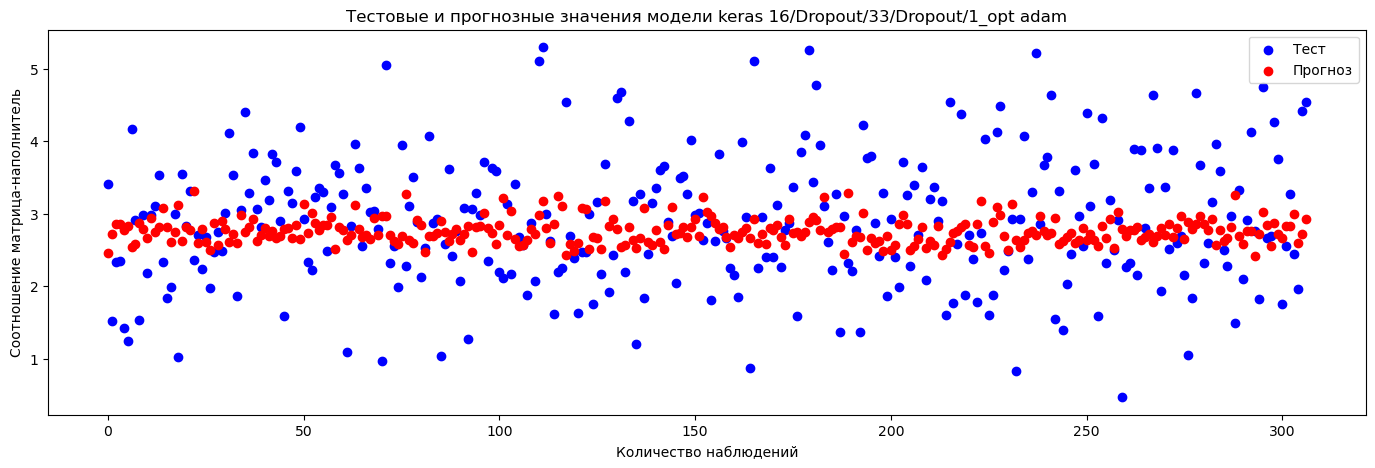

In [67]:
# визуализируем тестовые и прогнозные значения
plt.figure(figsize=(17,5))
plt.title('Тестовые и прогнозные значения модели keras 16/Dropout/33/Dropout/1_opt adam')
plt.scatter(y_test.index, y_test, label = 'Тест', color='b')
plt.scatter(predictions.index, predictions, label = 'Прогноз', color='r')
plt.legend(loc = 'best')
plt.ylabel('Соотношение матрица-наполнитель')
plt.xlabel('Количество наблюдений')
plt.show()

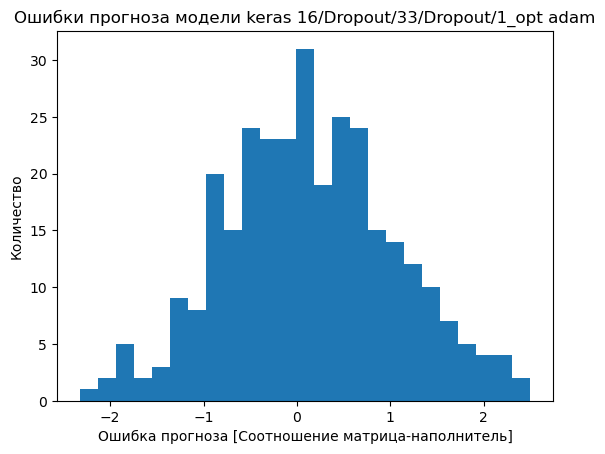

In [68]:
# визуализируем ошибки модели
error = np.array(y_test) - np.array(predictions)
plt.hist(error, bins=25)
plt.title('Ошибки прогноза модели keras 16/Dropout/33/Dropout/1_opt adam')
plt.xlabel('Ошибка прогноза [Соотношение матрица-наполнитель]')
_ = plt.ylabel('Количество')

**Заключение**

Создание новых композитных материалов - сложный и ресурсоемкий процесс. Для создания модели машинного обучения, которая давала бы точный прогноз по свойствам новых материалов необходимы не только навыки программирования и аналитики, но и знания предметной области. 
В ходе работы при подробном разведочном анализе данных выявлены совпадающие паттерны проекций, что наиболее вероятно отражает специфику произвосдтва образцов итогового материла, из свойств которых создавалась база данных. Однако, использовать полученную информацию наилучшим образом помогли бы специалисты в области композиционных материалов. 
Тем не менее, выполнена попытка разработки нескольких моделей машинного обучения, которые не смогли обучиться и с достаточной точностью спрогнозировать целевые переменные. 
Использовать взаимосвязи между переменными удалось только при написании нейронной сети, результат которой можно было бы улучшить при приложении дополнительных ресурсов. Например, усложнении архитектуры сети или использовании других активационных функций. 
Перспектива использования машинного обучения в области создания новых композитных материалов огромна и требует работы команды, имеющей в своем составе специалистов из различных областей. 